#<font color="red"> Fake News Detection for the United States Government </font>

##<font color="green"> Project Explanation </font>

This project aims to analyze two datasets: the first containing real news and the second containing fake news. The goal is to train a classification model capable of autonomously distinguishing between the two. The project is structured in the following steps:

1. Exploratory Data Analysis (EDA);
2. Selection of relevant variables for model training;
3. Data preprocessing;
4. Model training;
5. Model validation.

Once the initial training was completed, an additional model was trained to identify topics within the headlines of fake news articles. The objective was to determine which categories are more susceptible to misinformation.

In [1]:
#import libraries

import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns

In [2]:
#move into the work directory

%cd sample_data

/content/sample_data


In [3]:
df_true= pd.read_csv("True.csv")

df_fake= pd.read_csv("Fake.csv")

In [4]:
#add a columns containing the labels

df_true["target"]= "True"

df_fake["target"]= "Fake"

In [5]:
df_true.head()

,title,text,subject,date,target
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",True
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",True
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",True
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",True
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",True


In [6]:
df_fake.head()

,title,text,subject,date,target
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",Fake
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",Fake
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",Fake
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",Fake
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",Fake


#<font color="red"> Exploratory Data Anlysis </font>

In this section, a preliminary analysis was conducted to gain a broad understanding of the structure of the datasets.

Initially, a simple count of values for each news category was performed. From this, it emerged that the news categories can primarily be grouped into political news and news concerning the rest of the world, as clearly observed in the dataset containing real news.

In the dataset containing fake news, the articles are further divided into subcategories, which still reflect the same two main contexts identified in the real news dataset.

In [7]:
print(df_fake["subject"].value_counts())

print("------------")

print(df_true["subject"].value_counts())

subject
News               9050
politics           6841
left-news          4459
Government News    1570
US_News             783
Middle-east         778
Name: count, dtype: int64
------------
subject
politicsNews    11272
worldnews       10145
Name: count, dtype: int64


In [8]:
len(df_fake), len(df_true)

(23481, 21417)

In [9]:
#check nan values

print(df_fake.isna().sum())

print("------------")

print(df_true.isna().sum())

title      0
text       0
subject    0
date       0
target     0
dtype: int64
------------
title      0
text       0
subject    0
date       0
target     0
dtype: int64


Since dates are present in the dataset, even though they are not essential for fake news detection, they were still considered to identify potentially irrelevant records for the analysis.

A row without a valid date might contain other types of information that are not useful for training the model.

The following function aims to extract the years from the dates to identify records for which the function returns no value and analyze those observations.

Additionally, it allows for grouping all news categories by year within a pivot table, providing a more comprehensive overview of the dataset. The analysis reveals that fake news was most prevalent between 2016 and 2017.

In [10]:
years= ["2015", "2016", "2017", "-18"]

def year_cleaned(date):

  for i in years:

    try:

      if i in date:

        if i == "-18":

          return date.replace(date, "2018")

        else:

          return date.replace(date, i)

    except Exception as e:

      return e

df_fake["year"]=df_fake["date"].apply(year_cleaned)

df_true["year"]= df_true["date"].apply(year_cleaned)

In [11]:
pt_fake= pd.pivot_table(df_fake[["year", "subject"]],
                   index=df_fake["year"],
                   columns=df_fake["subject"],
                   aggfunc="count"
                   )["subject"]

pt_true= pd.pivot_table(df_true[["year", "subject"]],
                   index=df_true["year"],
                   columns=df_true["subject"],
                   aggfunc="count"
                   )["subject"]

In [12]:
print(pt_fake)

print("------------")

print(pt_true)

subject  Government News  Middle-east    News  US_News  left-news  politics
year                                                                       
2015               583.0          NaN     NaN      NaN      742.0    1160.0
2016               597.0        400.0  5841.0    405.0     1805.0    2706.0
2017               390.0        378.0  3209.0    378.0     1911.0    2937.0
2018                 NaN          NaN     NaN      NaN        NaN      35.0
------------
subject  politicsNews  worldnews
year                            
2016           4716.0        NaN
2017           6556.0    10145.0


Below are the indices for which the function returned no value.

Analyzing these records, it appears that they consist of links, which might refer to fake news articles. However, since only the website URLs are provided, they do not contribute any meaningful information to the model. Therefore, they can be removed.

In [13]:
df_fake.iloc[[9358, 15507, 15508, 18933]]

,title,text,subject,date,target,year
9358,https://100percentfedup.com/served-roy-moore-v...,https://100percentfedup.com/served-roy-moore-v...,politics,https://100percentfedup.com/served-roy-moore-v...,Fake,None
15507,https://100percentfedup.com/video-hillary-aske...,https://100percentfedup.com/video-hillary-aske...,politics,https://100percentfedup.com/video-hillary-aske...,Fake,None
15508,https://100percentfedup.com/12-yr-old-black-co...,https://100percentfedup.com/12-yr-old-black-co...,politics,https://100percentfedup.com/12-yr-old-black-co...,Fake,None
18933,Homepage,[vc_row][vc_column width= 1/1 ][td_block_trend...,left-news,MSNBC HOST Rudely Assumes Steel Worker Would N...,Fake,None


In [14]:
df_fake= df_fake.drop([9358, 15507, 15508, 18933], axis=0)

#<font color="red"> Dataset Preprocessing </font>

During the preprocessing phase, the following steps were carried out:

1. Creation of a text-cleaning function;
2. Creation of a function for text vectorization and dictionary generation;
3. Merging of the two datasets;
4. Application of the aforementioned functions and encoding of the target variable.

This method normalizes values based on the occurrence of a term within the dictionary, providing a measure of how important a word is to a document relative to the entire dataset.
The goal of these steps is to obtain a perfectly cleaned dataset that can be fed into the model.

In [15]:
import spacy

import nltk

from nltk.corpus import stopwords

import string

import re

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix

from sklearn.model_selection import learning_curve

In [16]:
#import the correct package from spacy; download the list of stopwords and punctuation, in order to remove them from the corpus

nlp= spacy.load("en_core_web_sm")

nltk.download("stopwords")

en_sw= stopwords.words("english")

punctuation= set(string.punctuation)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [17]:
#create the function to clean the dataset

def data_cleaner(sentences):

  clean_dataset=[]

  for sentence in sentences:

    sentence= sentence.lower()

    for i in punctuation:

      sentence= sentence.replace(i, " ")

    doc= nlp(sentence)

    sentence= " ".join(token.lemma_ for token in doc)

    sentence= " ".join(word for word in sentence.split() if word not in en_sw)

    sentence= re.sub(" +", " ", sentence)

    sentence= re.sub("/d", " ", sentence)

    clean_dataset.append(sentence)

  return clean_dataset

In [18]:
#create the function to encode the dataset and obtain the dictionary of words

def bow_tfidf(dataset, tfidf_vectorizer):

  if tfidf_vectorizer == None:

    tfidf_vectorizer= TfidfVectorizer()

    X= tfidf_vectorizer.fit_transform(dataset)

  else:

    X= tfidf_vectorizer.transform(dataset)

  return X.toarray(), tfidf_vectorizer

In [19]:
#concatenate the datasets

final_df= pd.concat([df_true, df_fake], ignore_index=True)[["title", "target"]]

In [20]:
len(final_df)

44894

In [21]:
#clean and vectorize the text dataset and encode dataset labels

from sklearn.preprocessing import LabelEncoder

le=LabelEncoder()

cleaned_labels=le.fit_transform(final_df["target"])

cleaned_text, vectorized= bow_tfidf(data_cleaner(final_df["title"]), None)

#<font color="red"> Search for the best parameters for the model</font>

This step is crucial for the model's application, as it aims to determine the best hyperparameters to optimize the model’s ability to understand relationships within the data.

A Multi-Layer Perceptron (MLP) Classifier was used for classification, which requires several hyperparameters to function correctly:

* Hidden layers: The number of hidden layers and the number of artificial neurons in each layer. In this case, two configurations were considered, both consisting of two hidden layers. The first configuration had 100 and 150 neurons, while the second had 150 and 200 neurons. Cross-validation determined that the best accuracy was achieved using the first configuration (100 and 150 neurons).
* Activation function: The sigmoid function was chosen for this binary classification problem.
* Solver: The optimizer used for weight adjustments was Adam, as it autonomously adapts the learning rate based on previous epochs, making it a more practical choice in this case.
* Tolerance (tol): The model's tolerance was set to 0.5, preventing it from learning excessively from the data and reducing the risk of overfitting.
* Max iterations (max_iter): The maximum number of iterations before the model reaches the specified tolerance.
* Verbose: Set to True to track the iterations during training.


In [22]:
#import libraries

from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import KFold

from sklearn.metrics import precision_score, recall_score

In [23]:
#use cross-validation to get the best params for the classifier

n_splits= 3

hidden_layers= [(100, 150, ), (150, 200, )]

tolerance= 0.5

dataset_text=cleaned_text

dataset_target= cleaned_labels

k_fold= KFold(n_splits=n_splits, shuffle=True, random_state=0)

scores=[]

for layer in hidden_layers:

  for train_index, test_index in k_fold.split(dataset_text):

    x_train, x_test= dataset_text[train_index], dataset_text[test_index]

    y_train, y_test= dataset_target[train_index], dataset_target[test_index]

    clf= MLPClassifier(hidden_layer_sizes= layer,
                        activation= "logistic",
                        solver="adam",
                        max_iter=100,
                        tol=tolerance,
                        verbose=True).fit(x_train, y_train)

    scores.append((clf.score(x_test, y_test), layer, x_train, y_train, x_test, y_test))

best_score=max(scores)

print(best_score[0], best_score[1])

Iteration 1, loss = 0.66600482
Iteration 2, loss = 0.30835899
Iteration 3, loss = 0.14288396
Iteration 4, loss = 0.10727409
Iteration 5, loss = 0.08675180
Iteration 6, loss = 0.07292691
Iteration 7, loss = 0.06213505
Iteration 8, loss = 0.05354435
Iteration 9, loss = 0.04660398
Iteration 10, loss = 0.04141437
Iteration 11, loss = 0.03641840
Iteration 12, loss = 0.03274301
Training loss did not improve more than tol=0.500000 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.65569086
Iteration 2, loss = 0.27624963
Iteration 3, loss = 0.13683678
Iteration 4, loss = 0.10344985
Iteration 5, loss = 0.08379457
Iteration 6, loss = 0.06982902
Iteration 7, loss = 0.05989413
Iteration 8, loss = 0.05194144
Iteration 9, loss = 0.04538612
Iteration 10, loss = 0.04016900
Iteration 11, loss = 0.03543961
Iteration 12, loss = 0.03227496
Training loss did not improve more than tol=0.500000 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.65838878
Iteration 2, loss = 0.28074111
Iteratio

 # <font color="red"> Model's evaluation </font>

Iteration 1, loss = 0.67621337
Iteration 2, loss = 0.37914310
Iteration 3, loss = 0.16083944
Iteration 4, loss = 0.11761732
Iteration 5, loss = 0.09563270
Iteration 6, loss = 0.08078959
Iteration 7, loss = 0.06941886
Iteration 8, loss = 0.06135999
Iteration 9, loss = 0.05372317
Iteration 10, loss = 0.04826450
Iteration 11, loss = 0.04361521
Iteration 12, loss = 0.03923862
Training loss did not improve more than tol=0.500000 for 10 consecutive epochs. Stopping.


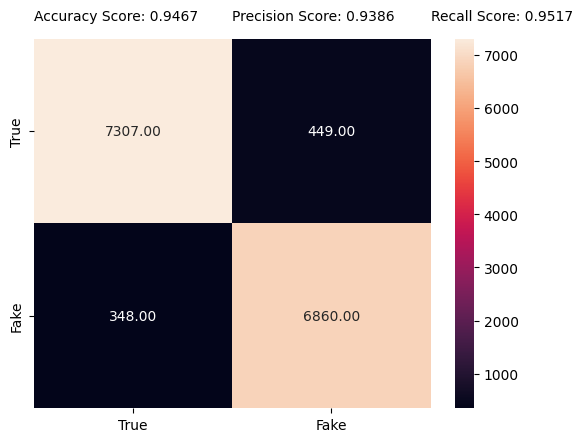

In [24]:
#train the model with the params obtained

clf= MLPClassifier(hidden_layer_sizes=(100, 150),
                   activation="logistic",
                   solver="adam",
                   max_iter=100,
                   tol=0.5,
                   verbose=True).fit(best_score[2], best_score[3])

sns.heatmap(confusion_matrix(best_score[5], clf.predict(best_score[4])), annot=True, fmt=".2f", xticklabels=["True", "Fake"], yticklabels=["True", "Fake"])

plt.text(0, -0.1, f"Accuracy Score: {np.round(clf.score(best_score[4], best_score[5]), 4)}")

plt.text(1, -0.1, f"Precision Score: {np.round(precision_score(best_score[5], clf.predict(best_score[4])), 4)}")

plt.text(2, -0.1, f"Recall Score: {np.round(recall_score(best_score[5], clf.predict(best_score[4])), 4)}")

plt.show()

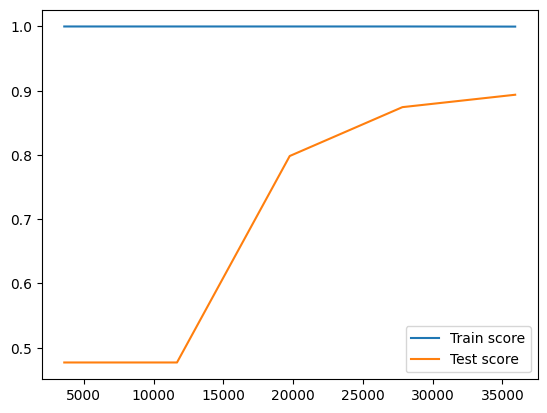

In [25]:
#plot the learning curve

train_size_abs, train_score, test_score= learning_curve(MLPClassifier(),
                                                        cleaned_text,
                                                        cleaned_labels,
                                                        random_state=0)

plt.plot(train_size_abs, train_score.mean(axis=1), label="Train score")

plt.plot(train_size_abs, test_score.mean(axis=1), label="Test score")

plt.legend()

plt.show()

In [ ]:
import pickle

In [ ]:
#save the model

pickle.dump(clf, open("My_model.pkl", "wb"))

In [ ]:
#load the model

model= pickle.load(open("My_model.pkl", "rb"))

#<font color="red"> Fake News Topic </font>

In this final part of the project, a model was trained to identify the most relevant topics within the headlines of fake news articles.

The steps carried out were as follows:

1. Definition and application of a text-cleaning function;
2. Creation and application of a function for text vectorization;
3. Generation of a word dictionary;
4. Use of the LdaMulticore object from the Gensim library to extract the most relevant topics.
This approach allows for a deeper understanding of the recurring themes in fake news headlines, helping to identify patterns and trends in misinformation.

In [ ]:
#import libraries

import gensim

from sklearn.feature_extraction.text import CountVectorizer

from gensim.utils import simple_preprocess

In [ ]:
#create a function to clean the dataset

def sent_to_item(sentences):

  for sentence in sentences:

    yield simple_preprocess(sentence)

In [ ]:
#create a function in order to remove the stopwords from dataset

def remove_sw(sentences):

  return [[word for word in sentence if word not in en_sw]for sentence in sentences]

In [ ]:
vector= df_fake["title"]

In [ ]:
data_words= list(sent_to_item(vector))

data_words= remove_sw(data_words)

In [ ]:
#create the words dictionary

id2word= gensim.corpora.Dictionary(data_words)

In [ ]:
#vectorize the dataset

corpus= [id2word.doc2bow(sentence) for sentence in data_words]

In [ ]:
#fit the model and print the topics

from pprint import pprint

model= gensim.models.LdaMulticore(corpus=corpus,
                                  id2word=id2word,
                                  num_topics=10,
                                  passes=10)

pprint(model.print_topics())

doc= model[corpus]

[(0,
  '0.049*"trump" + 0.026*"video" + 0.007*"president" + 0.007*"obama" + '
  '0.007*"watch" + 0.006*"new" + 0.005*"tweets" + 0.004*"donald" + '
  '0.004*"conway" + 0.004*"cruz"'),
 (1,
  '0.022*"video" + 0.011*"obama" + 0.008*"room" + 0.008*"boiler" + '
  '0.007*"america" + 0.007*"new" + 0.006*"ep" + 0.006*"white" + 0.005*"watch" '
  '+ 0.004*"bill"'),
 (2,
  '0.036*"trump" + 0.017*"video" + 0.011*"obama" + 0.010*"watch" + 0.009*"old" '
  '+ 0.006*"president" + 0.006*"yr" + 0.005*"says" + 0.004*"donald" + '
  '0.004*"meeting"'),
 (3,
  '0.047*"video" + 0.018*"trump" + 0.013*"obama" + 0.009*"white" + '
  '0.008*"watch" + 0.008*"breaking" + 0.007*"black" + 0.006*"police" + '
  '0.006*"new" + 0.005*"cops"'),
 (4,
  '0.044*"trump" + 0.024*"video" + 0.010*"obama" + 0.009*"black" + '
  '0.007*"watch" + 0.007*"tweets" + 0.006*"election" + 0.006*"white" + '
  '0.005*"hillary" + 0.005*"racist"'),
 (5,
  '0.042*"video" + 0.026*"trump" + 0.007*"obama" + 0.007*"news" + '
  '0.005*"black" + 0.00

The terms identified in the extracted topics reveal a strong presence of political references, which, as previously mentioned, dominate a significant portion of the news in the datasets.

In particular, fake news articles frequently focus on the U.S. presidency, as the most recurring terms include the names of the last two presidents, "Trump" and "Obama". Additionally, there are frequent mentions of "Bill" and "Hillary Clinton".